In [64]:
# This is needed so that python finds the utils
import sys
sys.path.append("/Users/gergelyflamich/Documents/Work/MLMI/miracle-compession/code")

# Needed for compression as the common source of randomness
from sobol_seq import i4_sobol_generate
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

$$
\newcommand{\N}{\mathbb{N}}
\newcommand{\X}{\mathcal{X}}
$$
The algorithm is as follows [1]:

**Rej-Sampler**$(P, Q)$
Random Input: $\langle x_i \mid i \in \N \rangle$ a sequence of i.i.d. samples from $Q$.

 1. Initialisation 
 
    1. For each $x \in \X$, set $p_0(x) \leftarrow 0$.
    2. Set $p^*_0 \leftarrow 0$.
    
 2. **For** $i \leftarrow 1$ to $\infty$ **do**
 
    1. Set $\alpha_i(x) \leftarrow \min\{P(x) - p_{i-1}(x), (1 - p^*_{i-1})Q(x) \} \quad \forall x \in \X$.
    2. Set $p_i(x) \leftarrow p_{i - 1}(x) + \alpha_i(x) \quad \forall x \in \X$.
    3. Set $p_i^* \leftarrow \sum_{x \in \X} p_i(x)$
    4. Set $\beta_i(x_i) \leftarrow \frac{\alpha_i(x)}{(1 - p^*_{i-1})Q(x)}$
    5. Sample $u \leftarrow \mathrm{Uniform}(0, 1)$
    6. **If** $u < \beta_i(x_i)$ **then**
    
        **return** $i, x_i$

In [116]:
def rejection_sampler(P, Q, seed, failure_threshold=1000):
    """
    P, Q - lists of positive reals that sum to one
    """
    
    np.random.seed(seed)
    
    n = len(P)
    
    # Initialisation
    alpha = [0] * n
    p = [0] * n
    p_star = 0
    
    # Rejection sampling loop
    for i in range(failure_threshold):
        
        p_star_ = 0
        
        # Step 2.A and 2.B
        for x in range(n):
            alpha[x] = np.minimum(P[x] - p[x], (1 - p_star) * Q[x])
            p[x] = p[x] + alpha[x]
            p_star_ += p[x]
            
        
        # Step 2.D and Step 2.C - we exchange these so that we don't need to keep
        # both p_star_i and p_star_{i - 1} around
        x_i = np.random.choice(n, None, p=Q)
        beta_i = alpha[x_i] / ((1 - p_star) * Q[x_i])
        
        p_star = p_star_
        
        # Step 2.E
        u = np.random.uniform()
        
        # Step 2.F
        if u < beta_i:
            return i, x_i
        
    return None

def kl_divergence(P, Q):
    return np.sum(P * (np.log(P) - np.log(Q)))
        

In [117]:
samples = []
mass = np.zeros(len(P))

for j in tqdm(range(50, 1050)):
    sample = rejection_sampler(P=P, Q=Q, seed=j, failure_threshold=1000)
    samples.append(sample)
    
    i, x_i = sample
    
    mass[x_i] += 1
    
mass = mass / np.sum(mass)

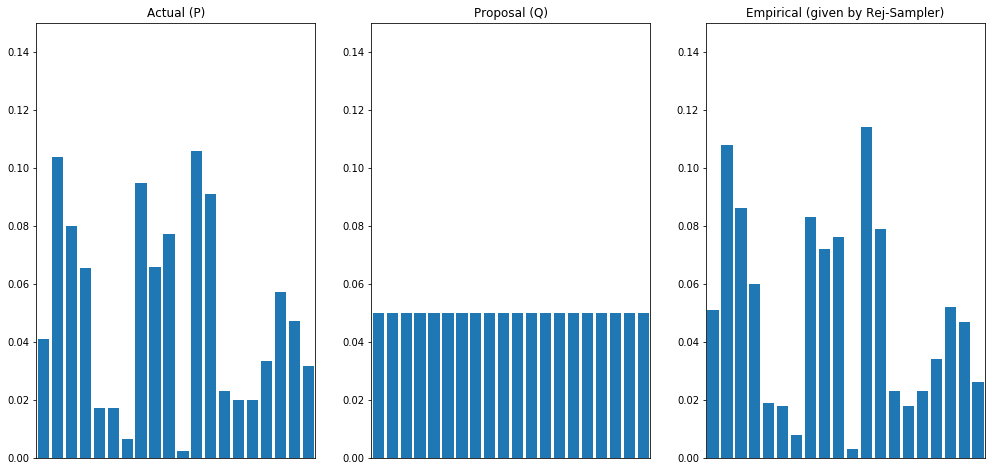

KL divergence between P and Q: 0.235


In [124]:
np.random.seed(42)

P = np.random.uniform(size=20)
P = P / np.sum(P)

Q = np.ones(len(P)) / len(P)

plt.figure(figsize=(17, 8))
plt.subplot(131)
plt.bar(np.arange(len(P)), P)
plt.ylim([0, 0.15])
plt.xlim([-0.5, 19.5])
plt.xticks([])
plt.title("Actual (P)")

plt.subplot(132)
plt.bar(np.arange(len(P)), Q)
plt.ylim([0, 0.15])
plt.xlim([-0.5, 19.5])
plt.xticks([])
plt.title("Proposal (Q)")

plt.subplot(133)
plt.bar(np.arange(len(P)), mass)
plt.ylim([0, 0.15])
plt.xlim([-0.5, 19.5])
plt.xticks([])
plt.title("Empirical (given by Rej-Sampler)")

plt.show()

print("KL divergence between P and Q: {:.3f}".format(kl_divergence(P, Q)))

References:

[1] Communication Cost of Correlation